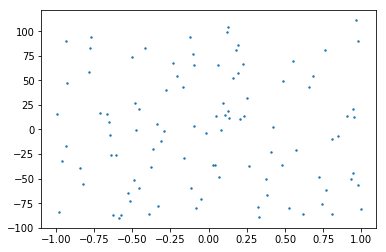

In [167]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Data
'''n = 100
x = np.linspace(0,1,n)
epis = np.random.uniform(-1,1,n)
y = np.sin(x + epis * (x/1)**1.1)'''

x = np.random.uniform(-1,1,n)
x2 = np.random.uniform(-1,1,n)
epis = np.random.uniform(-100,100,n)
y = 10 +  2*x + epis

plt.scatter(x, y, s = 2)

In [168]:
x = x.reshape(n, 1)
x.shape

(100, 1)

In [169]:
x = np.column_stack((x, x2))

## Non-Bayesian

In [170]:
# Network parameter
n_inputs = x.shape[1]
n_hidden1 = 1
n_outputs = 1

# tf Graph input
X_tf = tf.placeholder(tf.float32,
                  shape = (None, n_inputs),
                  name = 'X')
y_tf = tf.placeholder(tf.float32,
                  shape = (None),
                  name = 'y')

# Paraameters
learning_rate = 0.1
num_steps = 400
batch_size = 100
display_step = 50

# Layer weights and bias
weights = {
    'out': tf.Variable(tf.random_normal([n_inputs, n_outputs]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_outputs])), 
}

# Model
def neural_net(x):
    out_layer = tf.add(tf.matmul(x, weights['out']), biases['out'])
    
    return out_layer

In [171]:
# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model

# Initialize the variables
init = tf.global_variables_initializer()

In [172]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #batch_x = np.random.choice(x[:,0], batch_size).reshape(batch_size, 1)
        #batch_y = np.random.choice(y, batch_size)
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred = sess.run(NN, feed_dict={X_tf: x})


step 1, Minibatch Loss = 3281.7012
step 50, Minibatch Loss = 3274.5254
step 100, Minibatch Loss = 3274.5225
step 150, Minibatch Loss = 3274.5225
step 200, Minibatch Loss = 3274.5225
step 250, Minibatch Loss = 3274.5225
step 300, Minibatch Loss = 3274.5225
step 350, Minibatch Loss = 3274.5225
step 400, Minibatch Loss = 3274.5225
optimization finished


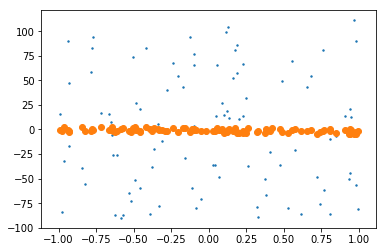

In [173]:
plt.scatter(x[:,0], y, s = 2)
plt.scatter(x[:,0], pred)


## Bayesian

In [174]:
neural_net = tf.keras.Sequential([
    tfp.layers.DenseFlipout(1)
])

# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables
init = tf.global_variables_initializer()

In [175]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred_mean = sess.run(NN, feed_dict={X_tf: x})
    
    # Draw sample for the weights and bias from the posterior
    w0_draw = neural_net.layers[0].kernel_posterior.sample(100).eval()
    #w1_draw = neural_net.layers[1].kernel_posterior.sample(100).eval()
    #w2_draw = neural_net.layers[2].kernel_posterior.sample(100).eval()
    b0_draw = neural_net.layers[0].bias_posterior.sample(100).eval()
    #b1_draw = neural_net.layers[1].bias_posterior.sample(100).eval()
    #b2_draw = neural_net.layers[2].bias_posterior.sample(100).eval()



step 1, Minibatch Loss = 3278.2898
step 50, Minibatch Loss = 3275.2634
step 100, Minibatch Loss = 3272.316
step 150, Minibatch Loss = 3274.124
step 200, Minibatch Loss = 3275.0654
step 250, Minibatch Loss = 3276.0007
step 300, Minibatch Loss = 3274.833
step 350, Minibatch Loss = 3278.6262
step 400, Minibatch Loss = 3278.347
optimization finished


In [176]:
def np_relu(x):
    return np.maximum(x, 0)

pred = []
for i in range(100):
    pred.append(np_relu(np_relu(x.dot(w0_draw[i])+b0_draw[i]).dot(w1_draw[i])+b1_draw[i]).dot(w2_draw[i])+b2_draw[i])

ValueError: shapes (100,1) and (10,10) not aligned: 1 (dim 1) != 10 (dim 0)

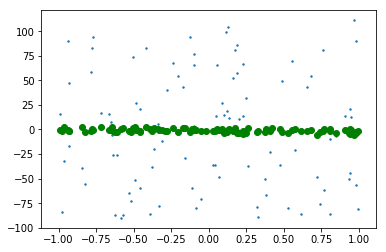

In [177]:
plt.scatter(x[:,0], y, s = 2)
'''for i in range(5):
    plt.plot(x, pred[i], c = 'r')'''
plt.scatter(x[:,0], pred_mean, c = 'g')





(array([ 3.,  1.,  6., 12., 18., 18., 16., 11.,  9.,  6.]),
 array([-3.52188611, -3.41318099, -3.30447588, -3.19577076, -3.08706565,
        -2.97836053, -2.86965542, -2.7609503 , -2.65224519, -2.54354007,
        -2.43483496]),
 <a list of 10 Patch objects>)

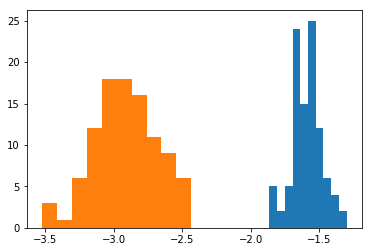

In [178]:
plt.hist(w0_draw[:,0])
plt.hist(w0_draw[:,1])

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([ 9.53766251,  9.63766251,  9.73766251,  9.83766251,  9.93766251,
        10.03766251, 10.13766251, 10.23766251, 10.33766251, 10.43766251,
        10.53766251]),
 <a list of 10 Patch objects>)

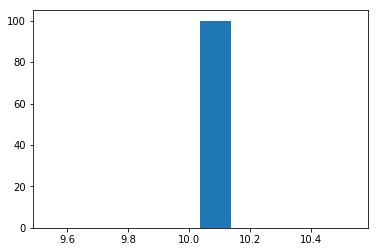

In [134]:
plt.hist(b0_draw[:,0])